In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import ee
import requests
import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured
import io
from typing import Tuple
import geemap
import jax
import numpy as np
import shutil
import os
import ml_collections
from flax.core import freeze, unfreeze
import orbax.checkpoint as ocp
import jax.numpy as jnp
from flax_model import (
    CNN_LandCover,
    CNN_LST,
    create_train_state,
    interpolate_invalid_temperatures,
    read_example
)
from plotly.graph_objects import Image
from plotly.subplots import make_subplots

In [2]:
PATCH_SIZE = 128
SCALE = 500
LANDSAT_BANDS = ["SR_B4", "SR_B3", "SR_B2"]
LAND_COVER_DATASET = "GOOGLE/DYNAMICWORLD/V1"  # Dynamic World Land Cover dataset
LANDSAT_VIS_PARAMS = {"bands": LANDSAT_BANDS, "min": 0, "max": 0.3}
LONLAT = -121.526, 39.781
# LONLAT = -124.01242497269993,68.04738277205375
LANDSAT_DATASET = "LANDSAT/LC08/C02/T1_L2"
CLASSIFICATIONS = {
    "💧 Water": "419BDF",
    "🌳 Trees": "397D49",
    "🌾 Grass": "88B053",
    "🌿 Flooded vegetation": "7A87C6",
    "🚜 Crops": "E49635",
    "🪴 Shrub and scrub": "DFC35A",
    "🏗️ Built-up areas": "C4281B",
    "🪨 Bare ground": "A59B8F",
    "❄️ Snow and ice": "B39FE1",
}

In [31]:
project = "ee-rohitp934"


def initialize_ee():
    ee.Authenticate()
    # ee.Initialize(project=project, opt_url="https://earthengine-highvolume.googleapis.com")
    ee.Initialize(project=project)

In [32]:
initialize_ee()

In [33]:
def mask_landsat8_clouds(image: ee.Image) -> ee.Image:
    """Mask clouds in Landsat 8 images."""
    CLOUD_SHADOW_BIT = 3
    CLOUD_BIT = 5
    qa = image.select("QA_PIXEL")
    cloud_mask = (
        qa.bitwiseAnd(1 << CLOUD_SHADOW_BIT)
        .eq(0)
        .And(qa.bitwiseAnd(1 << CLOUD_BIT).eq(0))
    )
    return image.updateMask(cloud_mask)

In [34]:
def apply_scale_factors(image):
    """Apply scale factors to Landsat 8 bands."""
    optical_bands = image.select("SR_B.").multiply(0.0000275).add(-0.2)
    thermal_bands = image.select("ST_B.*").multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

In [35]:
def get_landsat_image(date: datetime) -> ee.Image:
    """Gets a Landsat 8 image for the selected date."""
    start_date = ee.Date(date)
    end_date = ee.Date(date).advance(6, "month")
    return (
        ee.ImageCollection(LANDSAT_DATASET)
        .filterDate(start_date, end_date)
        # .map(mask_landsat8_clouds)
        # .map(apply_scale_factors)
        .mosaic()
    )

In [36]:
def get_landsat_image(
    datetime: datetime = datetime.now() - relativedelta(years=2),
    default_value: float = 0.0,
) -> ee.Image:
    """Get a Landsat image for the given year."""
    start = ee.Date(datetime)
    end = ee.Date(datetime).advance(6, "month")
    return (
        ee.ImageCollection(LANDSAT_DATASET)
        .filterDate(start, end)
        # .map(mask_landsat8_clouds)
        # .map(apply_scale_factors)
        .mosaic()
        .float()
    )

In [37]:
def get_landsat_ndvi(image: ee.Image) -> ee.Image:
    """Calculates NDVI from a Landsat 8 image."""
    return image.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI")

In [38]:
def get_landsat_lst(image: ee.Image) -> ee.Image:
    """
    Calculates Land Surface Temperature from a Landsat 8 image.
    This function is based on the formula in the following page https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2
    """
    return image.select("ST_B10").rename("LST")

In [39]:
def get_land_cover(date: datetime, advance: int = 6) -> ee.Image:
    """Gets a Land Cover image for the given date."""
    start_date = ee.Date(date)
    end_date = ee.Date(date).advance(advance, "month")
    return (
        ee.ImageCollection(LAND_COVER_DATASET)
        .filterDate(start_date, end_date)
        .select("label")
        .mosaic()
        .unmask(0)  # fill missing values with 0 (water)
        .byte()
    )

In [40]:
def get_lst(date: datetime) -> ee.Image:
    """Gets the Land Surface Temperature for the given date."""

    landsat_image = get_landsat_image(date)

    return get_landsat_lst(landsat_image)

In [41]:
def get_modis_ndvi(date: datetime) -> ee.Image:
    """Gets MODIS NDVI data for a given date."""
    start_date = ee.Date(date)
    end_date = ee.Date(date).advance(1, "month")
    return (
        ee.ImageCollection("MODIS/061/MOD13Q1")
        .filterDate(start_date, end_date)
        .select("NDVI")
        .first()
    )

In [42]:
def get_inputs_image(date: datetime) -> ee.Image:
    """Gets an Earth Engine image with all the inputs for the model."""
    # Get MODIS NDVI
    modis_ndvi = get_modis_ndvi(date)

    # Get Landsat data
    landsat_image = get_landsat_image(date)
    landsat_ndvi = get_landsat_ndvi(landsat_image)
    landsat_lst = get_landsat_lst(landsat_image)

    combined_ndvi = ee.Image.cat([landsat_ndvi, modis_ndvi])

    # Combine all input data
    return ee.Image([combined_ndvi, landsat_lst])

In [43]:
def get_patch(
    image: ee.Image, lonlat: Tuple[float, float], patch_size: int, scale: int
) -> np.ndarray:
    """Fetches a patch of pixels from Earth Engine."""
    point = ee.Geometry.Point(lonlat)
    url = image.getDownloadURL(
        {
            "region": point.buffer(scale * patch_size / 2, 1).bounds(1),
            "dimensions": [patch_size, patch_size],
            # "scale": SCALE,
            "format": "NPY",
        }
    )

    # Retry on "Too Many Requests" errors
    response = requests.get(url)
    if response.status_code == 429:
        raise Exception("Too Many Requests")

    # Raise other exceptions
    response.raise_for_status()
    return np.load(io.BytesIO(response.content), allow_pickle=True)

In [44]:
def get_inputs_patch(
    date: datetime, lonlat: Tuple[float, float], patch_size: int
) -> np.ndarray:
    """Gets the inputs patch of pixels for the given point and date."""
    image = get_inputs_image(date)
    patch = get_patch(image, lonlat, patch_size, SCALE)
    return structured_to_unstructured(patch)


def get_labels_landcover_patch(
    date: datetime, lonlat: Tuple[float, float], patch_size: int
) -> np.ndarray:
    """Gets the labels patch of pixels in LandCover for the given point and year."""
    image = get_land_cover(date + relativedelta(weeks=24))
    patch = get_patch(image, lonlat, patch_size, SCALE)
    return structured_to_unstructured(patch)


def get_labels_lst_patch(
    date: datetime, lonlat: Tuple[float, float], patch_size: int
) -> np.ndarray:
    """Gets the labels patch of pixels in LST for the given point and year."""
    image = get_lst(date + relativedelta(weeks=24))
    patch = get_patch(image, lonlat, patch_size, SCALE)
    return structured_to_unstructured(patch)

In [131]:
def render_landsat(image: ee.Image) -> geemap.Map:
    """Renders a Landsat image."""
    map = geemap.Map()
    map.set_center(LONLAT[0], LONLAT[1], 9)
    map.scroll_wheel_zoom = False
    map.dragging = False
    map.add_layer(image, LANDSAT_VIS_PARAMS, "Landsat 8 Satellite Image")
    map.addLayerControl()
    return map


render_landsat(get_landsat_image(datetime.strptime("2020-01-01", "%Y-%m-%d")))

Map(center=[39.781, -121.526], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [45]:
model_lc = CNN_LandCover()
model_lst = CNN_LST()
config = ml_collections.ConfigDict()

config.learning_rate = 0.001
config.batch_size = 32
config.img_size = 128
config.num_epochs = 250
config.train_test_split = 0.9

rng = jax.random.key(0)
rng, init_rng = jax.random.split(rng)
init_lc_state = create_train_state(init_rng, config, "lc")
lc_pytree = {"model": init_lc_state}
init_lst_state = create_train_state(init_rng, config, "lst")
lst_pytree = {"model": init_lst_state}

In [46]:
lc_ckpt_dir = os.path.abspath("../models/flax/lc/checkpoints")
lc_ckpt_manager = ocp.CheckpointManager(
    lc_ckpt_dir,
)
lc_params = lc_ckpt_manager.restore(249, args=ocp.args.StandardRestore(lc_pytree))

In [168]:
input = get_inputs_patch(
    datetime.strptime("2020-01-01", "%Y-%m-%d"), LONLAT, PATCH_SIZE
)
input = np.expand_dims(input, axis=0)
input = interpolate_invalid_temperatures(input)
input.shape

(1, 128, 128, 3)

In [25]:
input = np.load("../v2/flax/lc/train/epoch_100/lc/images.npy")
print(input.shape)

(1814, 128, 128, 3)


In [26]:
label = np.load("../v2/flax/lc/train/epoch_100/lc/labels.npy")
print(label.shape)

(1814, 128, 128, 1)


In [27]:
pred = np.load("../v2/flax/lc/train/epoch_100/lc/preds.npy")
print(pred.shape)

(1814, 128, 128, 9)


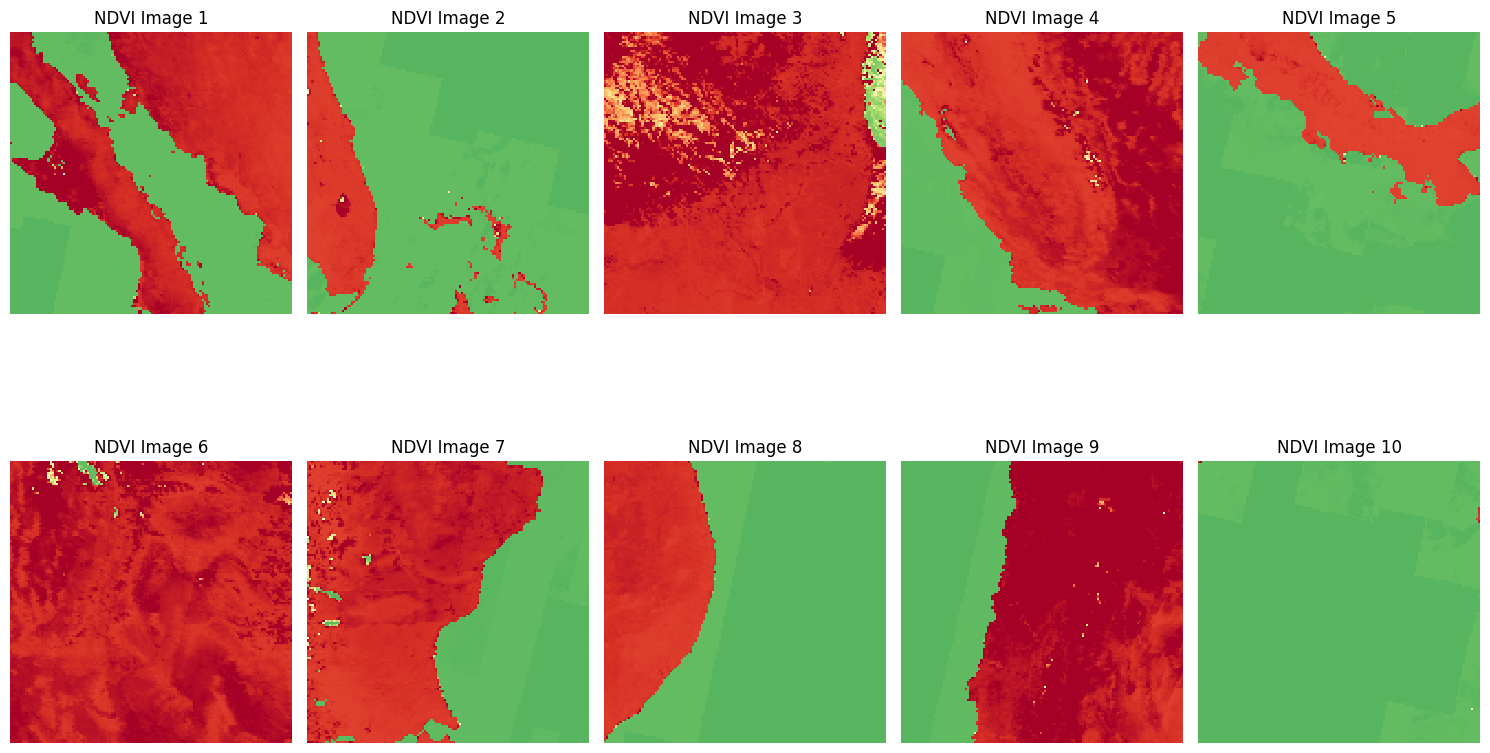

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def render_ndvi_as_rgb(ndvi: np.ndarray, min_val: float = -1, max_val: float = 1) -> np.ndarray:
    """Converts an NDVI array into an RGB image using a colormap.

    Args:
        ndvi: A float array with NDVI values ranging from -1 to 1.
        min_val: The minimum value for normalization (default -1 for NDVI).
        max_val: The maximum value for normalization (default 1 for NDVI).

    Returns:
        A uint8 array with shape (width, height, rgb) representing RGB values.
    """
    # Normalize NDVI to the 0-1 range based on its theoretical min/max values of -1 to 1
    ndvi_normalized = (ndvi - min_val) / (max_val - min_val)
    # Apply a colormap (e.g., 'viridis' for continuous data, 'RdYlGn' for diverging color mapping more suitable for NDVI)
    colormap = plt.get_cmap('RdYlGn')
    ndvi_rgb = colormap(ndvi_normalized)  # This returns RGBA where A is alpha (opacity)
    # Convert RGBA to RGB by ignoring the alpha channel and multiplying by 255 for uint8
    ndvi_rgb = (ndvi_rgb[..., :3] * 255).astype(np.uint8)
    return ndvi_rgb

def show_inputs(inputs: np.ndarray, num_images: int = 10) -> None:
    """Shows the first 'num_images' NDVI data as RGB images using matplotlib."""
    plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
    for i in range(min(num_images, inputs.shape[0])):
        ndvi_image = inputs[i, :, :, 0]  # Assuming the NDVI is in the first channel
        rgb_image = render_ndvi_as_rgb(ndvi_image)
        ax = plt.subplot(2, 5, i + 1)  # Adjust the grid size as needed
        ax.imshow(rgb_image, interpolation='nearest')
        ax.set_title(f"NDVI Image {i+1}")
        ax.axis('off')  # Turn off axis numbers and ticks
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'input_images' is a batch of images and you want to visualize the first 10
show_inputs(input)

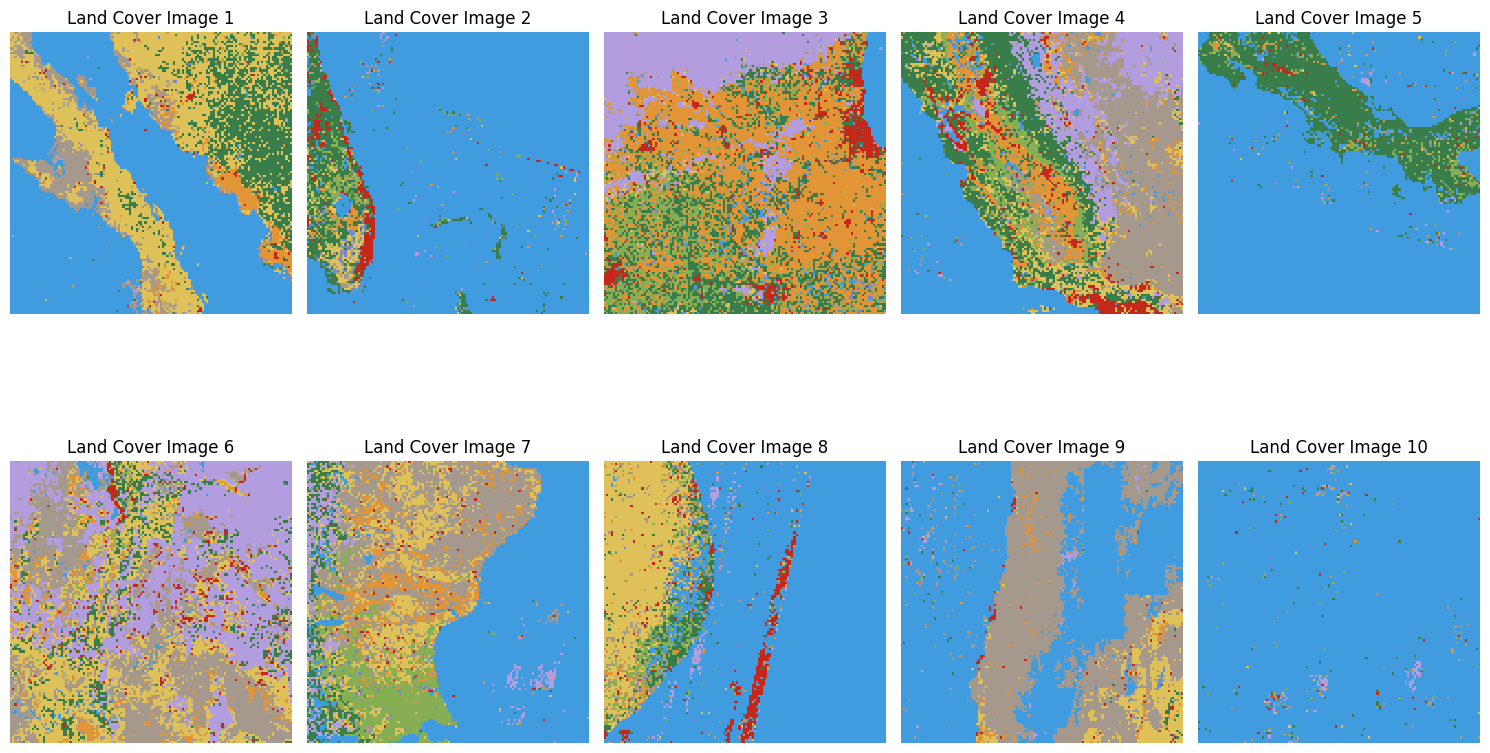

In [29]:
import numpy as np
import matplotlib.pyplot as plt


def render_classifications(values: np.ndarray, palette: list[str]) -> np.ndarray:
    """Renders a classifications NumPy array with shape (width, height) as an RGB image.

    Args:
        values: An uint8 array with shape (width, height).
        palette: List of hex encoded colors.

    Returns: An uint8 array with shape (width, height, rgb) with colors from the palette.
    """
    # Prepare the color map array
    xs = np.linspace(0, len(palette), 256)
    indices = np.arange(len(palette))

    red = np.interp(xs, indices, [int(c[0:2], 16) for c in palette])
    green = np.interp(xs, indices, [int(c[2:4], 16) for c in palette])
    blue = np.interp(xs, indices, [int(c[4:6], 16) for c in palette])

    color_map = np.array([red, green, blue]).astype(np.uint8).transpose()
    color_indices = (values / len(palette) * 255).astype(np.uint8)
    return np.take(color_map, color_indices, axis=0)


def render_landcover(patch: np.ndarray, pred: bool = False) -> np.ndarray:
    """Renders a land cover image."""
    if pred:
        patch = patch.argmax(-1)
    else:
        patch = patch.squeeze()
    palette = list(CLASSIFICATIONS.values())
    return render_classifications(
        patch, palette
    )  # Ensure patch is squeezed in case it has an extra dimension


def show_outputs(outputs: np.ndarray, num_images: int = 10) -> None:
    """Shows the first 'num_images' land cover output data as images using matplotlib."""
    plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
    for i in range(min(num_images, outputs.shape[0])):
        landcover_image = render_landcover(outputs[i])
        ax = plt.subplot(2, 5, i + 1)  # Adjust the grid size as needed
        ax.imshow(landcover_image, interpolation="nearest")
        ax.set_title(f"Land Cover Image {i+1}")
        ax.axis("off")  # Turn off axis numbers and ticks
    plt.tight_layout()
    plt.show()

def show_predictions(preds: np.ndarray, num_images: int = 10) -> None:
    """Shows the first 'num_images' land cover output data as images using matplotlib."""
    plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
    for i in range(min(num_images, preds.shape[0])):
        landcover_image = render_landcover(preds[i], pred=True)
        ax = plt.subplot(2, 5, i + 1)  # Adjust the grid size as needed
        ax.imshow(landcover_image, interpolation="nearest")
        ax.set_title(f"Land Cover Image {i+1}")
        ax.axis("off")  # Turn off axis numbers and ticks
    plt.tight_layout()
    plt.show()


show_outputs(label)

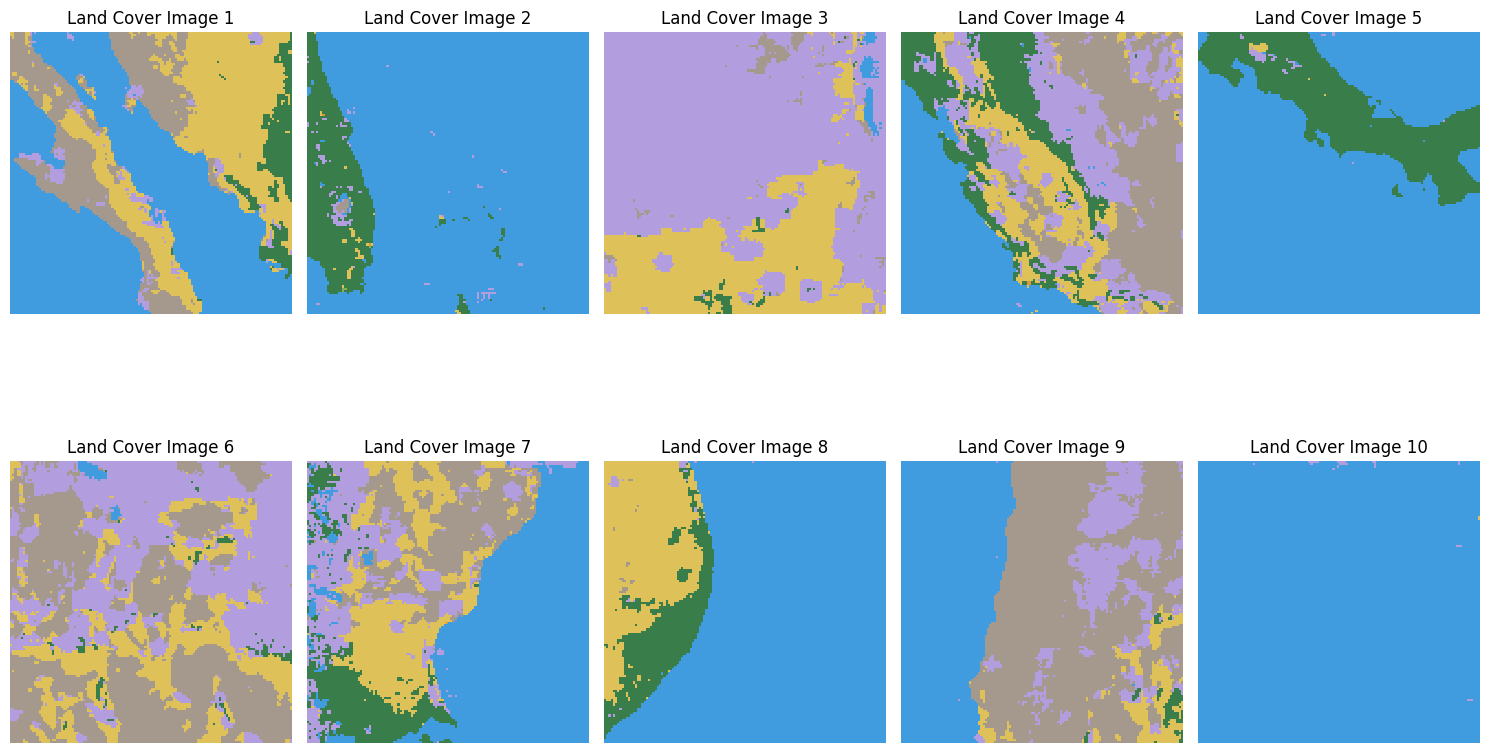

In [30]:
show_predictions(pred)

In [169]:
import geemap


def render_input(image: ee.Image) -> geemap.Map:
    """Renders a Modis image."""

    LONLAT = -121.526, 39.781
    VIS_PARAMS = {
        "bands": ["NDVI"],
        "min": -1,
        "max": 1,
        "palette": [
            "ffffff",
            "ce7e45",
            "df923d",
            "f1b555",
            "fcd163",
            "99b718",
            "74a901",
            "66a000",
            "529400",
            "3e8601",
            "207401",
            "056201",
            "004c00",
            "023b01",
            "012e01",
            "011d01",
            "011301",
        ],
    }
    map = geemap.Map()
    map.set_center(LONLAT[0], LONLAT[1], 9)
    map.scroll_wheel_zoom = False
    map.dragging = False
    map.add_layer(image, VIS_PARAMS, "Landsat 8 Satellite Image")
    map.addLayerControl()
    return map


render_input(
    get_landsat_ndvi(get_landsat_image(datetime.strptime("2020-01-01", "%Y-%m-%d")))
)

Map(center=[39.781, -121.526], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [136]:
def get_input_patch_all_bands(
    date: datetime, lonlat: Tuple[float, float], patch_size: int
) -> np.ndarray:
    """Gets the inputs patch of pixels for the given point and date."""
    image = get_landsat_image(date)
    patch = get_patch(image, lonlat, patch_size, SCALE)
    return structured_to_unstructured(patch)

In [137]:
input_rgb = get_input_patch_all_bands(
    datetime.strptime("2020-01-01", "%Y-%m-%d"), LONLAT, PATCH_SIZE
)

input_rgb.shape

(128, 128, 19)

In [62]:
output = model_lc.apply({"params": lc_params["model"].params}, input[:1])[0]

In [63]:
output.shape

(128, 128, 9)

In [64]:
print(output[0])

[[ 0.25564742  0.5500064  -0.27070796 ... -0.2994331   1.6506996
   1.6495581 ]
 [ 0.2187634   0.3237685  -0.6754331  ... -0.00924695  2.4535234
   1.539046  ]
 [ 0.53963107  0.47527322 -0.64310485 ...  0.13822365  3.060609
   1.8334804 ]
 ...
 [-0.6034597   0.45953026 -0.00722594 ... -1.4567872  -0.5891683
   0.58954376]
 [-1.0715203   0.2950024   0.09818985 ... -2.3380878  -2.4049973
   0.02118763]
 [-1.0710548   0.39371204  0.02727798 ... -2.3743656  -2.5654354
  -0.11506277]]


In [154]:
def render_classifications(values: np.ndarray, palette: list[str]) -> np.ndarray:
    """Renders a classifications NumPy array with shape (width, height, 1) as an image.

    Args:
        values: An uint8 array with shape (width, height, 1).
        palette: List of hex encoded colors.

    Returns: An uint8 array with shape (width, height, rgb) with colors from the palette.
    """
    # Create a color map from a hex color palette.
    xs = np.linspace(0, len(palette), 256)
    indices = np.arange(len(palette))

    red = np.interp(xs, indices, [int(c[0:2], 16) for c in palette])
    green = np.interp(xs, indices, [int(c[2:4], 16) for c in palette])
    blue = np.interp(xs, indices, [int(c[4:6], 16) for c in palette])

    color_map = np.array([red, green, blue]).astype(np.uint8).transpose()
    color_indices = (values / len(palette) * 255).astype(np.uint8)
    return np.take(color_map, color_indices, axis=0)


def render_landcover(patch: np.ndarray) -> np.ndarray:
    """Renders a land cover image."""
    palette = list(CLASSIFICATIONS.values())
    return render_classifications(patch, palette)


def show_outputs(outputs: np.ndarray) -> None:
    """Shows the outputs/labels data as an image."""
    fig = make_subplots(rows=1, cols=1, subplot_titles=("Land cover",))
    fig.add_trace(Image(z=render_landcover(outputs)), row=1, col=1)
    fig.show()

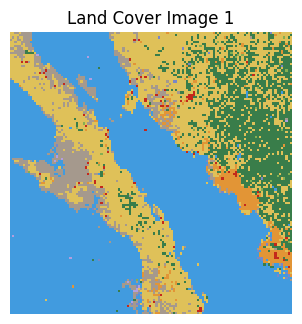

In [51]:
show_outputs(label[0:1])

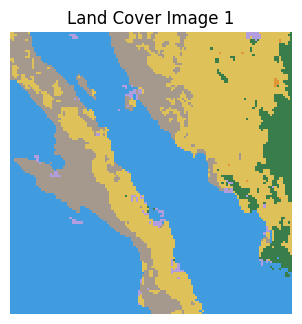

In [66]:
show_predictions(np.expand_dims(output, axis=0))

In [32]:
np.savetxt("output.csv", output, delimiter=",")